# INSTRUCTIONS
* [RUN THIS KERNEL](https://www.kaggle.com/nazmuddhohaansary/gcspath-for-rice-leaf-9-class-data)
* Collect The GCS PATH: such as

```'gs://kds-33dc5d420bc7282a4b7955000de5511010e42953a4fb70942d1b0112'```
* Set The GCS_PATH="The value we got"

In [1]:
GCS_PATH='gs://kds-f3ed004f8a8a306f551b4a91eff60029741819adc523b8aea193b0b4' # @param

# Installations

In [2]:
from IPython.display import clear_output
!pip install -U image-classifiers
!pip install -U efficientnet
clear_output()

# Mount Drive
* change working directory

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/Research_process/local_A/ensemble_models/

/content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models


In [6]:
ls -la

total 9
-rw------- 1 root root  348 Nov 15 12:03 config.json
drwx------ 2 root root 4096 Nov 27 17:48 Ensemble/
drwx------ 2 root root 4096 Nov 27 17:48 MODELS/


# PARAMETERS


In [7]:
import os
from glob import glob
MODELS=[_path for _path in glob(os.path.join(os.getcwd(),"MODELS","*.*"))]
DATA_FOLDER =    "content/drive/MyDrive/Research_process/tfrecords"
print("--------------------AVAILABLE MODELS----------------------------------------------")
print("----------------------------------------------------------------------------------")
model_names=[]
for MODEL in MODELS:
  model_name=os.path.basename(MODEL).split(".")[0]
  print(model_name)
  model_names.append(model_name)
  print("----------------------------------------------------------------------------------")
MODEL_NAME="_".join(model_names)
MODEL_NAME="ensamble_"+MODEL_NAME
print(MODEL_NAME)

--------------------AVAILABLE MODELS----------------------------------------------
----------------------------------------------------------------------------------
densenet121
----------------------------------------------------------------------------------
mobilenet
----------------------------------------------------------------------------------
xception
----------------------------------------------------------------------------------
ensamble_densenet121_mobilenet_xception


In [8]:
import os
EPOCHS      =    80   # @param
BUFFER_SIZE =    2048
MODEL_DIR   =    os.path.join(os.getcwd(),"Ensemble",f'{MODEL_NAME}')
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

WEIGHT_PATH=os.path.join(MODEL_DIR,"model.h5")
GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}/'

print(GCS_PATH)
print(WEIGHT_PATH)
print(MODEL_DIR)



gs://kds-f3ed004f8a8a306f551b4a91eff60029741819adc523b8aea193b0b4/content/drive/MyDrive/Research_process/tfrecords/
/content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/Ensemble/ensamble_densenet121_mobilenet_xception/model.h5
/content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/Ensemble/ensamble_densenet121_mobilenet_xception


# Config Reading

In [9]:
import json

with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_train_data']
NB_EVAL    =  config['nb_eval_data']

config

{'image_type': 'rgb',
 'img_dim': 256,
 'labels': ['algal_leaf',
  'Anthracnose',
  'bird_eye_spot',
  'brown_blight',
  'gray_light',
  'healthy',
  'red_leaf_spot',
  'white spot'],
 'nb_channels': 3,
 'nb_classes': 8,
 'nb_eval_data': 7920,
 'nb_train_data': 20160}

# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [10]:
import tensorflow as tf
import os


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.15.0
Running on TPU  


REPLICAS:  8


## Training Params

In [11]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = NB_TRAIN//BATCH_SIZE
EVAL_STEPS      = NB_EVAL//BATCH_SIZE
print(STEPS_PER_EPOCH,EVAL_STEPS)

157 61


## Data input function

In [12]:
from classification_models.tfkeras import Classifiers
import efficientnet.tfkeras as efn

def get_model(model_path):
  model_name=os.path.basename(model_path).split(".")[0]
  if "EfficientNet" not in model_name:
    classifier, _ = Classifiers.get(model_name)
  else:
    classifier=getattr(efn,model_name)
  net=classifier(input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),include_top=False,weights=None)
  for layer in net.layers:
      layer.trainable = False

  inp=net.input
  x=net.output
  x=tf.keras.layers.GlobalAveragePooling2D()(x)
  x=tf.keras.layers.Dropout(0.1)(x)
  x=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(x)
  model=tf.keras.Model(inputs=inp,outputs=x)
  model.load_weights(model_path)
  print(f"Loaded:{model_path}")
  return model,model_name

def ensamble_model(model_paths):
  models=[]
  names=[]
  for model_path in model_paths:
    model,mname=get_model(model_path)
    models.append(model)
    names.append(mname)
  ensamble_inputs=[model.input for model in models]
  ensamble_outputs=[model.output for model in models]
  merge=tf.keras.layers.Concatenate()(ensamble_outputs)
  out=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(merge)
  model=tf.keras.models.Model(inputs=ensamble_inputs,outputs=out)
  print(ensamble_inputs)
  return model

with strategy.scope():
    model=ensamble_model(MODELS)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

Loaded:/content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/MODELS/densenet121.h5
Loaded:/content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/MODELS/mobilenet.h5
Loaded:/content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/MODELS/xception.h5
[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>, <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>]


In [13]:
names=[]
for n in model.inputs:
  names.append(n.name)
  print(n.name)
#model.get_layer(index =1).name

input_1
input_2
input_3


In [14]:
def data_input_fn(mode):
    '''
      This Function generates data from gcs
    '''

    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))

        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        images={}
        for model_name in names:
          images[model_name]=image
        return images,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# Data Check

dict_keys(['input_1', 'input_2', 'input_3'])
input_1
(128, 256, 256, 3)


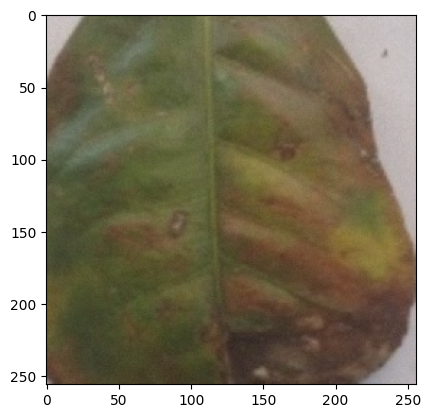

Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 8)
['algal_leaf', 'Anthracnose', 'bird_eye_spot', 'brown_blight', 'gray_light', 'healthy', 'red_leaf_spot', 'white spot']
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")


for x,y in eval_ds.take(1):
  print(x.keys())
  for model_name in names:
      print(model_name)
      print(x[f"{model_name}"].shape)
      data=np.squeeze(x[f"{model_name}"][0])
      plt.imshow(data)
      plt.show()
      print('Image Batch Shape:',x[f"{model_name}"].shape)
      print('Target Batch Shape:',y.shape)
      print(LABELS)
      print(y[0])
      break

# MODEL definition


## Callbacks
**CHANGABLE**

In [16]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True,
                                                  verbose=1,
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                  verbose=1,
                                                  mode = 'auto')

callbacks = [mode_autosave, lr_reducer,early_stopping ]


In [17]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/80
157/157 [==============================] - ETA: 0s - loss: 1.9923 - accuracy: 0.1553
Epoch 1: val_loss improved from inf to 1.86004, saving model to /content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/Ensemble/ensamble_densenet121_mobilenet_xception/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 297s 1s/step - loss: 1.9923 - accuracy: 0.1553 - val_loss: 1.8600 - val_accuracy: 0.3865 - lr: 1.0000e-04
Epoch 2/80
157/157 [==============================] - ETA: 0s - loss: 1.6341 - accuracy: 0.5036
Epoch 2: val_loss improved from 1.86004 to 1.79197, saving model to /content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/Ensemble/ensamble_densenet121_mobilenet_xception/model.h5
157/157 [==============================] - 112s 718ms/step - loss: 1.6341 - accuracy: 0.5036 - val_loss: 1.7920 - val_accuracy: 0.3981 - lr: 1.0000e-04
Epoch 3/80
157/157 [==============================] - ETA: 0s - loss: 1.5315 - accuracy: 0.5525
Epoch 3: val_loss improved from 1.79197 to 1.71002, saving model to /content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A/ensemble_models/Ensemble/ensamble_densenet121_mobilenet_xception/model.h5
157/157 [==================

## Model history

# Results



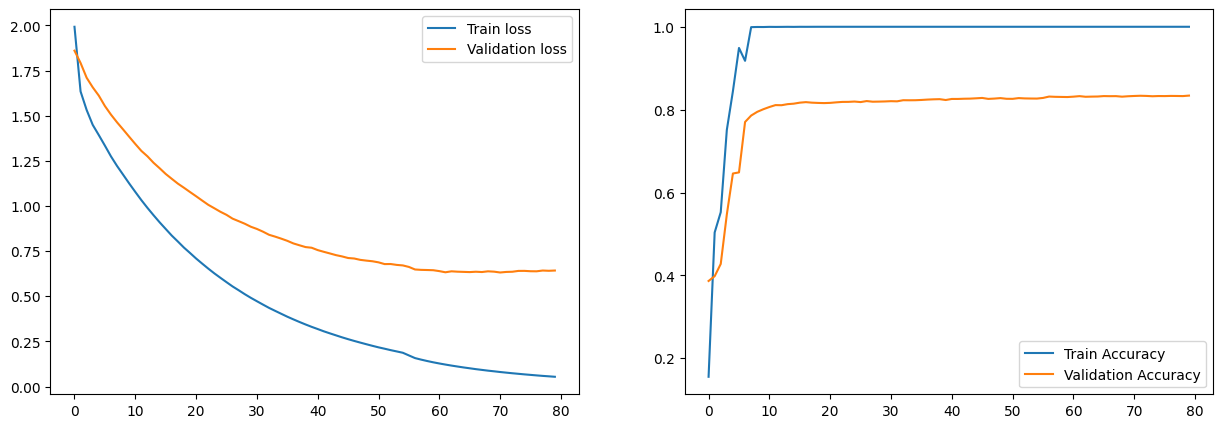

In [18]:
def plot_history(history,MODEL_DIR,iden):
    """
    Plots model training history
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax_acc.legend()
    plt.savefig( os.path.join(MODEL_DIR,f"{iden}.png"))
    plt.show()

# show history
plot_history(history,MODEL_DIR,f"{MODEL_NAME}")

# Model Evaluation on pure testing

In [19]:
model.load_weights(WEIGHT_PATH)
test_ds   =   data_input_fn("test")
result = model.evaluate(test_ds,steps=EVAL_STEPS )
dict(zip(model.metrics_names, result))

61/61 [==============================] - 32s 449ms/step - loss: 0.4063 - accuracy: 0.9070


{'loss': 0.4063388705253601, 'accuracy': 0.9070184230804443}

In [20]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

  0%|          | 0/61 [00:00<?, ?it/s]

4/4 [==============================] - 1s 51ms/step


# Saving

In [21]:
from sklearn.metrics import classification_report
report =classification_report(gts, preds, target_names=LABELS,output_dict=True)
report

{'algal_leaf': {'precision': 0.7464788732394366,
  'recall': 0.8145491803278688,
  'f1-score': 0.7790298873101421,
  'support': 976.0},
 'Anthracnose': {'precision': 0.8346595932802829,
  'recall': 0.9701952723535457,
  'f1-score': 0.8973384030418251,
  'support': 973.0},
 'bird_eye_spot': {'precision': 0.7378995433789954,
  'recall': 0.8321318228630278,
  'f1-score': 0.782187802516941,
  'support': 971.0},
 'brown_blight': {'precision': 0.7291666666666666,
  'recall': 0.9682377049180327,
  'f1-score': 0.8318661971830986,
  'support': 976.0},
 'gray_light': {'precision': 0.8661764705882353,
  'recall': 0.6065911431513903,
  'f1-score': 0.7135069654754694,
  'support': 971.0},
 'healthy': {'precision': 0.9839679358717435,
  'recall': 1.0,
  'f1-score': 0.9919191919191919,
  'support': 982.0},
 'red_leaf_spot': {'precision': 0.9214758751182592,
  'recall': 0.9948927477017364,
  'f1-score': 0.9567779960707269,
  'support': 979.0},
 'white spot': {'precision': 0.9691358024691358,
  'recall

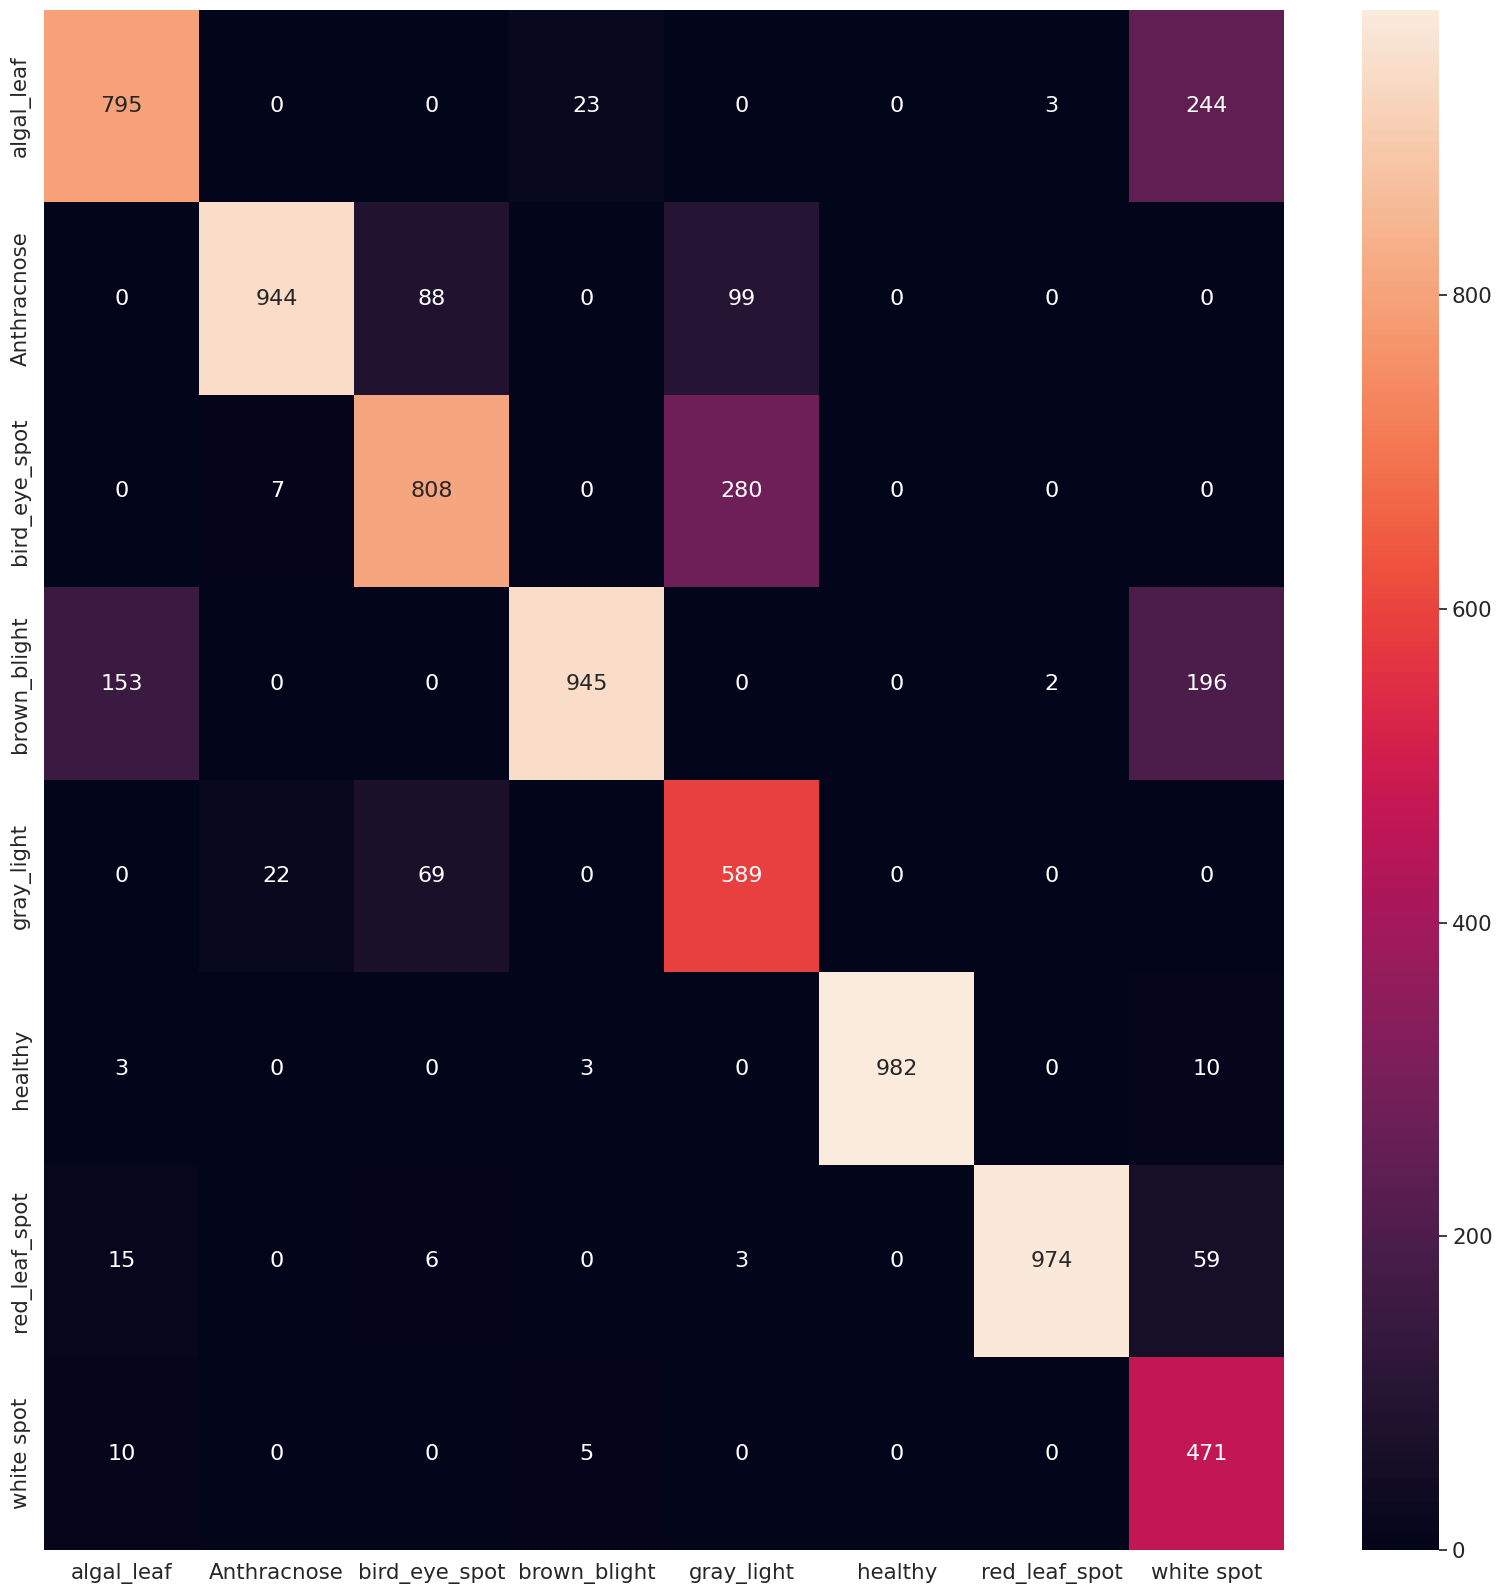

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
con_mat=confusion_matrix(preds, gts)
df_cm = pd.DataFrame(con_mat,
                     index = LABELS,
                     columns = LABELS)
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
plt.savefig( os.path.join(MODEL_DIR,f"confusion_{MODEL_NAME}.png"))
plt.show()